# Chapter 10 Exercises

In [1]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)

2022-12-27 18:02:01.370341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pandas as pd

import patsy

from sklearn.model_selection import train_test_split

import os

import rpy2.robjects as robjects
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri

import statsmodels.formula.api as smf
import statsmodels.api as sm

## Exercise 6
Consider the simple function $R(\beta)=sin(\beta)+\beta/10$

### 6a) 
Draw a graph of this function over the range $\beta\in[-6,6]$

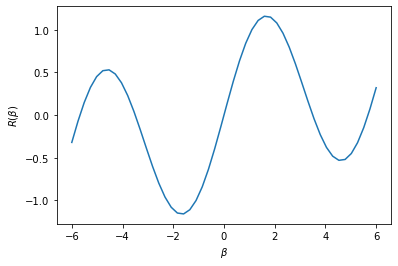

In [3]:
beta = np.linspace(-6, 6)

y = np.sin(beta) + beta * 1/10

plt.plot(beta, y)
plt.xlabel(r'$\beta$')
plt.ylabel(r'$R(\beta)$');

### 6b)  
What is the derivative of this function?
$R\prime(\beta) = cos(\beta)+1/10$

### 6c) 
Given $\beta^0 = 2.3$, run gradient descent to find a local minimum of $R(\beta)$ using a learning rate of $\rho=0.1$.  Show each of $\beta^0, \beta^1,...$ in your plot, as well as the final answer.

In [4]:
def find_local_min(b_0, p = 0.1):
    import numpy as np
    
    betas = []

    keep_running = True
    
    while keep_running:
        betas.append(b_0)
        current_deriv = np.cos(b_0) + 1/10
        
        if current_deriv < 0:
            b_0 += p
            current_deriv = np.cos(b_0) + 1/10 
            #print(b_0, current_deriv, keep_running)
            if current_deriv > 0:
                keep_running = False
                #print(b_0, current_deriv, keep_running)
        elif current_deriv > 0:
            b_0 -= p
            current_deriv = np.cos(b_0) + 1/10
            
            if current_deriv < 0:
                keep_running = False       
        
    betas.append(b_0)
    return betas

In [5]:
b = find_local_min(2.3)

In [6]:
first_betas = b[0:3]
optimal_beta = b[-1]

min_beta = min(b)
max_beta = max(b)

xt = np.append(np.arange(min_beta - 1, max_beta + 1, 1), first_betas)
xt = np.round(xt, decimals = 1)
xt = np.append(xt, optimal_beta)
xt = np.sort(xt)
xt = np.unique(xt)

In [7]:
num_betas = len(b)

xt_labels = []
i = 0

for item in xt:
    if b[0] <= item <= b[2]:
        xt_labels.append(fr'$\beta^{i}$')
        i += 1
    elif item == optimal_beta:
        xt_labels.append(fr'$\beta^{{{num_betas}}}$')
    else:
        xt_labels.append(item)

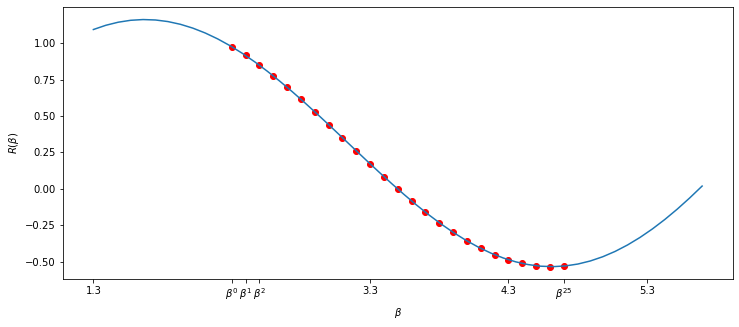

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,5))

x = np.linspace(min_beta - 1, max_beta + 1)

ax.plot(x, np.sin(x) + np.array(x) / 10)
ax.scatter(b, np.sin(b) + np.array(b) / 10, color='red')
ax.set_xticks(xt, labels = xt_labels)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$R(\beta)$');

### 6d)
Repeat with $\beta^0 = 1.4$ 

In [9]:
c = find_local_min(1.4)

In [10]:
first_betas = c[0:3]
optimal_beta = c[-1]

min_beta = min(c)
max_beta = max(c)


xt = np.append(np.arange(min_beta - 1.3, max_beta + 0.7, 1), first_betas)
xt = np.round(xt, decimals=1)
xt = np.append(xt, optimal_beta)
xt = np.sort(xt)
xt = np.unique(xt)

In [11]:
num_betas = len(c)

xt_labels = []
i = 2

for item in xt:
    if c[2] <= item <= c[0]:
        xt_labels.append(fr'$\beta^{i}$')
        i -= 1
    elif item == optimal_beta:
        xt_labels.append(fr'$\beta^{{{num_betas}}}$')
    else:
        xt_labels.append(item)

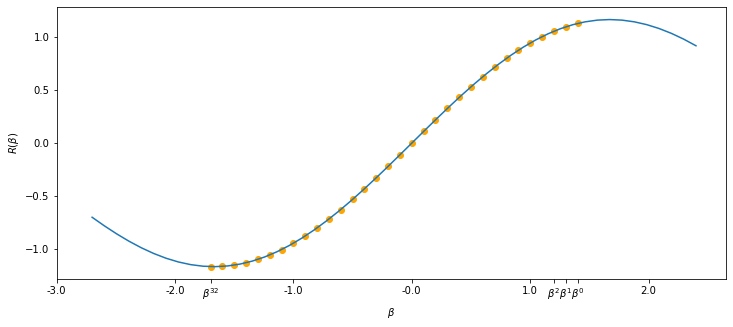

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,5))

x = np.linspace(min_beta - 1, max_beta + 1)

ax.plot(x, np.sin(x) + np.array(x) / 10)
ax.scatter(c, np.sin(c) + np.array(c) / 10, color='orange')
ax.set_xticks(xt, labels = xt_labels)
ax.set_xlabel(r'$\beta$')
ax.set_ylabel(r'$R(\beta)$');

## Exercise 7
Fit a neural network to the `Default` data.  Use a single hidden layer with 10 units, and dropout regularization.  Have a look at Labs 10.9.1-10.9.2 for guidance.  Compare the classification performance of your model with that of logistic regression.

In [13]:
default = pd.read_csv("../../../datasets/Default.csv")

In [14]:
default.head()

default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879

In [15]:
def formula_from_cols(df, y):
    return y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y])

In [16]:
formula_string = formula_from_cols(default, 'default')

In [17]:
formula_string

'default ~ student + balance + income'

In [18]:
def convert_to_int(x):
    if x == 'Yes':
        return 1
    else:
        return 0

In [19]:
default['default_int'] = default['default'].apply(convert_to_int)

In [20]:
x = patsy.dmatrix(formula_like = 'student + balance + income - 1', data = default)

x_scale = patsy.scale(x, ddof=1)

y = np.array(default['default_int'])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y, test_size = 0.2, random_state=42)

### Neural Network

In [22]:
modnn = tf.keras.Sequential(
    [
            tf.keras.layers.Dense(units = 10,
                                  activation='relu'),
            tf.keras.layers.Dropout(rate=0.4),
            tf.keras.layers.Dense(units=1, activation='sigmoid')
    ]
)

2022-12-27 18:02:08.379693: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
modnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics='accuracy'
             )

In [24]:
history = modnn.fit(x_train, 
                    y_train, 
                    epochs = 30, 
                    batch_size = 128, 
                    validation_data = (x_test, y_test), 
                    verbose = 0)

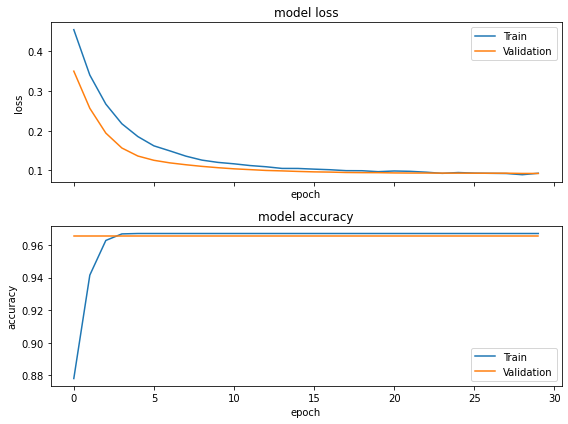

In [25]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout();

In [26]:
modnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                50        
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


In [27]:
y_proba = modnn.predict(x_test)
y_pred_classes = y_proba > 0.5

63/63 [==============================] - 0s 1ms/step


In [28]:
modnn_acc = np.mean(y_pred_classes.flatten() == y_test)
modnn_acc

0.9655

### Logistic Regression

In [29]:
modlr = tf.keras.Sequential(
    [
            tf.keras.layers.Dense(units = 1,
                                  activation='sigmoid')
    ]
)

In [30]:
modlr.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics='accuracy'
             )

In [31]:
history = modlr.fit(x_train, 
                    y_train, 
                    epochs = 30, 
                    batch_size = 128, 
                    validation_data = (x_test, y_test), 
                    verbose = 0)

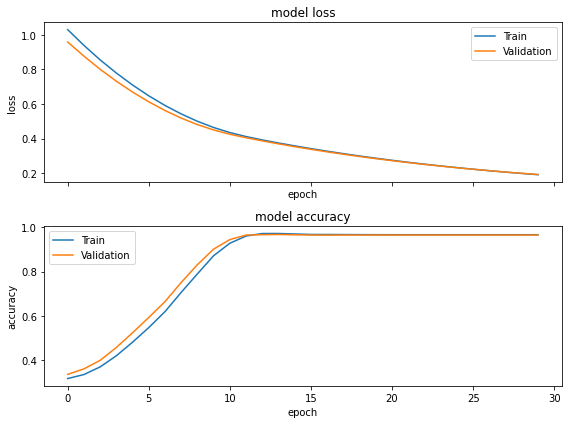

In [32]:
fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['Train', 'Validation'])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])
ax[1].set_title('model accuracy')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].legend(['Train', 'Validation'])

plt.tight_layout();

In [33]:
y_proba = modlr.predict(x_test)
y_pred_classes = y_proba > 0.5

63/63 [==============================] - 0s 802us/step


In [34]:
modlr_acc = np.mean(y_pred_classes.flatten() == y_test)
modlr_acc

0.9655

In [35]:
modlr.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


### Comparison

The performance of the neural network and logistic regression is about the same.  Both produce accuracy of roughly 97%.

## Exercise 8
From your collection of personal photographs, pick 10 images of animals (such as dogs, cats, birds, farm animals, etc.).  If the subject does not occupy a reasonable part of the image, then crop the image.  Now use a pretrained image classification CNN as in Lab 10.9.4 to predict the class of each of your images, and report the probabilities for the top five predicted classes for each image.

Note: I didn't have many personal photographs of pets other than my own, so to add some variety I used pictures of other items that I had in my photo library.  I also wanted to throw in some edge cases and see how the model handles them.

In [36]:
img_dir = '/Users/rancher/Google Drive/Coding/ISLR2/Python/chp10/exercises/images'

image_names = os.listdir(img_dir)

num_images = len(image_names)

x = []
for img_name in image_names:
    if not img_name.startswith('.'):
        img_path = img_dir + '/' + img_name
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        x.append(tf.keras.preprocessing.image.img_to_array(img))

x = np.array(x)

x = tf.keras.applications.imagenet_utils.preprocess_input(x)

In [37]:
cnnmodel = tf.keras.applications.resnet50.ResNet50(weights='imagenet')

In [38]:
cnnpred = cnnmodel.predict(x)
decoded_preds = tf.keras.applications.imagenet_utils.decode_predictions(cnnpred, top=5)
#decoded_preds

1/1 [==============================] - 2s 2s/step


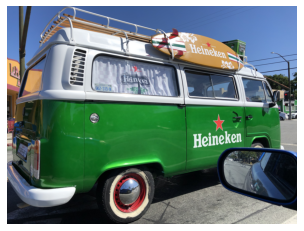

('n03769881', 'minibus', 0.24555771)
('n04467665', 'trailer_truck', 0.08731773)
('n04146614', 'school_bus', 0.06163805)
('n02930766', 'cab', 0.060142025)
('n03796401', 'moving_van', 0.059713505)


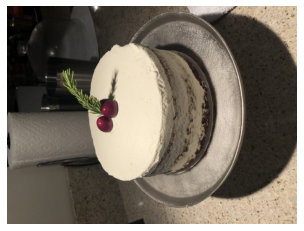

('n03124170', 'cowboy_hat', 0.9126676)
('n04259630', 'sombrero', 0.07880388)
('n03249569', 'drum', 0.0018769427)
('n03063689', 'coffeepot', 0.0008863048)
('n03447721', 'gong', 0.0008755055)


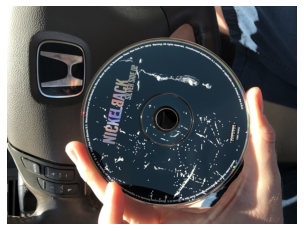

('n03841143', 'odometer', 0.2978302)
('n04355933', 'sunglass', 0.12564981)
('n04229816', 'ski_mask', 0.07844473)
('n02841315', 'binoculars', 0.073966585)
('n03724870', 'mask', 0.059940714)


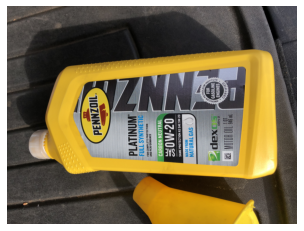

('n02966687', "carpenter's_kit", 0.25465685)
('n02747177', 'ashcan', 0.15323737)
('n04557648', 'water_bottle', 0.083209455)
('n04525305', 'vending_machine', 0.05932414)
('n03902125', 'pay-phone', 0.0534481)


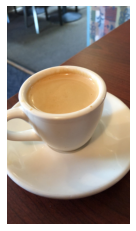

('n07920052', 'espresso', 0.656867)
('n07930864', 'cup', 0.14898956)
('n04263257', 'soup_bowl', 0.13640676)
('n03063599', 'coffee_mug', 0.024589831)
('n07584110', 'consomme', 0.007993312)


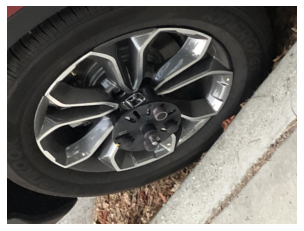

('n02974003', 'car_wheel', 0.9945623)
('n03208938', 'disk_brake', 0.0032293145)
('n02950826', 'cannon', 0.00054628093)
('n03777568', 'Model_T', 0.00047989862)
('n02797295', 'barrow', 0.00034961881)


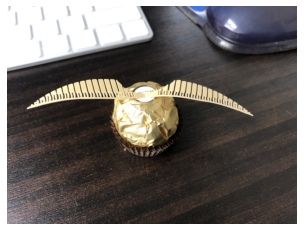

('n03793489', 'mouse', 0.18693356)
('n03388183', 'fountain_pen', 0.09736249)
('n03814906', 'necklace', 0.0951579)
('n02910353', 'buckle', 0.066841885)
('n04328186', 'stopwatch', 0.06403568)


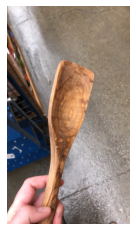

('n04597913', 'wooden_spoon', 0.9503716)
('n03720891', 'maraca', 0.042795505)
('n03633091', 'ladle', 0.0022342277)
('n03873416', 'paddle', 0.0014497068)
('n01943899', 'conch', 0.0010853888)


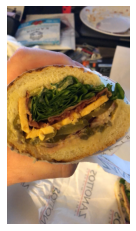

('n07697537', 'hotdog', 0.77166235)
('n07717410', 'acorn_squash', 0.055242945)
('n07697313', 'cheeseburger', 0.053534817)
('n07684084', 'French_loaf', 0.019278914)
('n07565083', 'menu', 0.01853296)


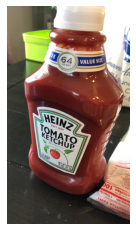

('n04560804', 'water_jug', 0.273655)
('n03950228', 'pitcher', 0.10948345)
('n03775546', 'mixing_bowl', 0.088263355)
('n04398044', 'teapot', 0.053894497)
('n03871628', 'packet', 0.037231382)


In [39]:
i=0

for img_name in image_names:
    if not img_name.startswith('.'):
        img_path = img_dir + '/' + img_name
        img = mpimg.imread(img_path)

        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
        for pred in decoded_preds[i]:
            print(pred)
        
        i+=1

### Summary

Above you can see the pictures I passed to the Convolutional Neural Network (CNN) and the classification with the top 5 highest probabilities.  

The CNN assigned a low probability (25%) of being a minibus to the Volkswagon van, however that's a good classification and is basically correct.  The rest of the predictions are all in a similar vein, trailer truck, school bus, etc.  The CNN was sure it was a vehicle of sorts, so I wonder why its top guess had such a low probability.  If I had to guess, I think the probability would have been higher if there wasn't a surfboard attached to the van.  Since that's such a distinct feature, which isn't likely to be found on the types of pictures the CNN would have been trained on, it made the classification harder.

The CNN assigned a very high (91%) probability that the cake was a cowboy hat, which isn't too bad of a guess to be honest.  With the cake stand, the profile is exactly that of a cowboy hat and is fairly distinct.  Given that the other guesses included sombrero, drum, and gong the profile must be a major factor in the CNN's classification.

Next the CD was incorrectly classified as an odometer.  This is another case of where I probably should have cropped the image because I'd guess the steering wheel in the background negatively affected the classification.  The rest of the guesses aren't related to cars though, so perhaps the pattern on the face of the CD may have also made the classification harder.  Had the CD been flipped, so that the characteristic reflective side was showing, or if the picture had been cropped, the CNN might have made better predictions.

None of the guesses really make a lot of sense for the motor oil picture and the guess with the highest probability (25%) was a carpenter's kit.  With the funnel slightly visible to the side, guesses related to tools make some sense though and the water bottle guess was on the right track, however ash can, vending machine, and pay-phone are way off.

It correctly classified the cup of espresso and the car wheel, but guessed mouse on the Ferrero Rocher chocolate candy that was decorated to look like a golden snitch from Harry Potter, which seems reasonable to me.  The golden snitch's wings make the Ferrero Rocher appear to have whiskers or a tail that's attached to a small body, almost as if it was a mouse.

A correct classification on the wooden spoon, with a reasonable classification of hotdog on what's actually a sandwich.  If you're of the mind that anything with two pieces of bread with something in between them is a sandwich, then a hotdog is a sandwich anyways; it seems that the CNN agrees.  
 
Lastly, the CNN assigned a low probability (27%) for its predictions of water jug on the ketchup bottle.  A ketchup bottle is a jug of sorts and ketchup does contain water, so this prediction makes some sense.

There were 4 correct classifications (5 if you consider a hotdog and sandwich to be the same thing), with only two classifications that didn't really make any sense at all (the CD and motor oil).  While the rest of the predictions weren't correct, they were reasonable at least.  Overall, not too bad for an out of the box, pretrained image classification model.

## Exercise 9
Fit a lag-5 autoregressive model to the `NYSE` data, as described in the text and in Lab 10.9.6.  Refit the model with a 12-level factor representing the month.  Does this factor improve the performance of the model?

### Lag-5 Linear Autoregressive (AR) logistic regression model with day_of_month variable

In [40]:
data = robjects.r("""
library(ISLR2)
xdata <- NYSE[, c("DJ_return", "log_volume", "log_volatility")]
""")
with localconverter(robjects.default_converter + pandas2ri.converter):
    xdata = robjects.conversion.rpy2py(data)

xdata = (xdata - xdata.mean()) / xdata.std()

In [41]:
data = robjects.r("""
library(ISLR2)
xdata <- NYSE[, "train"]
""")
istrain = np.array(data)

istrain = istrain[5:]

training_mask = istrain.astype(bool)

In [42]:
data = robjects.r("""
library(ISLR2)
xdata <- NYSE[, 'date']
""")

month_df = pd.DataFrame(np.array(data), columns=['date'])
month_df['date'] = pd.to_datetime(month_df['date'])
month_df['month'] = month_df['date'].dt.month
month_df['month_name'] = month_df['date'].dt.month_name()
month_df['day_of_week'] = month_df['date'].dt.day_name()

In [43]:
def lagm(df, prefix, k=1):
    num_rows, num_cols = df.shape
    
    null_df = pd.DataFrame(np.ones(shape=(k, num_cols)) * np.nan,
                           columns = df.columns)
    
    padded_df = pd.concat([null_df, df[:-k]], ignore_index=True)
    #padded_df.index += 1
    
    for column in padded_df.columns:
        padded_df = padded_df.rename(columns={column: prefix + '_' + column})
    
    return padded_df

In [44]:
arframe = pd.concat(
    [
        xdata[['log_volume']].reset_index(drop=True),
        lagm(xdata, 'L1', 1), 
        lagm(xdata, 'L2', 2),
        lagm(xdata, 'L3', 3),
        lagm(xdata, 'L4', 4),
        lagm(xdata, 'L5', 5)
    ], axis=1
)

arframe = arframe[5:]

arframemonth = pd.concat([month_df[['month_name', 'day_of_week']][5:], arframe], axis=1)

In [45]:
arframemonth.head()

month_name day_of_week  log_volume  L1_DJ_return  L1_log_volume  \
5   December      Monday    0.605868      0.046336       0.224760   
6   December     Tuesday   -0.013660     -1.304018       0.605868   
7   December   Wednesday    0.042548     -0.006293      -0.013660   
8   December    Thursday   -0.419802      0.377050       0.042548   
9   December      Friday   -0.556019     -0.411684      -0.419802   

   L1_log_volatility  L2_DJ_return  L2_log_volume  L2_log_volatility  \
5          -2.500763     -0.431361       0.935098          -2.366325   
6          -1.365915      0.046336       0.224760          -2.500763   
7          -1.505543     -1.304018       0.605868          -1.365915   
8          -1.551386     -0.006293      -0.013660          -1.505543   
9          -1.597475      0.377050       0.042548          -1.551386   

   L3_DJ_return  L3_log_volume  L3_log_volatility  L4_DJ_return  \
5      0.434777       2.283601          -2.417837      0.905125   
6     -0.431361       0.935098          -2.366325      0.434777   
7      0.046336       0.224760          -2.500763     -0.431361   
8     -1.304018       0.605868          -1.365915      0.046336   
9     -0.006293      -0.013660          -1.505543     -1.304018   

   L4_log_volume  L4_log_volatility  L5_DJ_return  L5_log_volume  \
5       1.517165          -2.528849     -0.549778       0.175060   
6       2.283601          -2.417837      0.905125       1.517165   
7       0.935098          -2.366325      0.434777       2.283601   
8       0.224760          -2.500763     -0.431361       0.935098   
9       0.605868          -1.365915      0.046336       0.224760   

   L5_log_volatility  
5          -4.356718  
6          -2.528849  
7          -2.417837  
8          -2.366325  
9          -2.500763

In [46]:
formula_string = formula_from_cols(arframemonth, 'log_volume')
formula_string

'log_volume ~ month_name + day_of_week + L1_DJ_return + L1_log_volume + L1_log_volatility + L2_DJ_return + L2_log_volume + L2_log_volatility + L3_DJ_return + L3_log_volume + L3_log_volatility + L4_DJ_return + L4_log_volume + L4_log_volatility + L5_DJ_return + L5_log_volume + L5_log_volatility'

In [47]:
armodelmonth = smf.ols(formula=formula_string, 
                       data = sm.add_constant(arframemonth[training_mask]))

arfitmonth = armodelmonth.fit()

arpredmonth = arfitmonth.predict(arframemonth[~training_mask])

V_0 = arframe[~training_mask]['log_volume'].var()
r_2 = 1 - np.mean((arpredmonth - arframemonth[~training_mask]['log_volume']) ** 2) / V_0
r_2

0.4629871767872078

### Comparison

The $R^2$ of the lag-5 AR model that has been refit with a 12-level factor for the month is 0.4630, which is slightly higher than the $R^2$ of 0.4599 from Lab 10.9.6.

## Exercise 10
In Section 10.9.6, we showed how to fit a linear AR model to the `NYSE` data using the `lm()` (`statsmodelsformulas.ols` in Python) function.  However, we also mentioned that we can "flatten" the short sequences produced for the RNN model in order to fit a linear AR model.  Use this latter approach to fit a linear AR model to the `NYSE` data.  Compare the test $R^2$ of this linear AR model to that of the linear AR model that we fit in the lab.  What are the advantages/disadvantages of each approach?

### Lag-5 Linear Autoregressive (AR) neural network model without day_of_week variable

In [48]:
n = arframe.shape[0]
xrnn = pd.DataFrame(arframe.iloc[:,1:])
xrnn = np.array(xrnn)
xrnn = xrnn.reshape((n, 3, 5), order='F')
xrnn = xrnn[:,:,::-1]
xrnn = xrnn.transpose((0,2,1))
xrnn.shape

(6046, 5, 3)

In [49]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = 1)
    ]
)

model.compile(optimizer='rmsprop', loss='mse')

In [50]:
history = model.fit(
    x = xrnn[training_mask, :, :],
    y = arframe[training_mask]['log_volume'],
    batch_size = 64, epochs = 200,
    validation_data = (xrnn[~training_mask, :, :], 
                       arframe[~training_mask]['log_volume']),
    verbose = 0
)

kpred = model.predict(xrnn[~training_mask])
r_2 = 1 - np.mean((kpred.flatten() - arframe[~training_mask]['log_volume'])**2) / V_0
r_2

56/56 [==============================] - 0s 1ms/step


0.41369677997785503

The Linear AR model from the lab using `lm()` (`statsmodelsformulas.ols` in Python) has a test $R^2$ of 0.4132, which is very close to the $R^2$ above generated from using a neural network with a Flatten() layer.  Performance between the two models is very similar.


Advantages:
Need to do

Disadvantanges:
Need to do

## Exercise 11
Repeat the previous exercise, but now fit a nonlinear AR model by "flattening" the short sequences produced for the RNN model.

### Lag-5 Non-Linear AR Recurrent Neural Network (RNN) model without day_of_week variable

In [51]:
n = arframe.shape[0]
xrnn = pd.DataFrame(arframe.iloc[:,1:])
xrnn = np.array(xrnn)
xrnn = xrnn.reshape((n, 3, 5), order='F')
xrnn = xrnn[:,:,::-1]
xrnn = xrnn.transpose((0,2,1))
xrnn.shape

(6046, 5, 3)

In [52]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.SimpleRNN(units=15,
                         dropout=0.1,
                         recurrent_dropout=0.1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1)
    ]
)

model.compile(optimizer='rmsprop', loss='mse')

history = model.fit(
    x = xrnn[training_mask],
    y = arframe[training_mask][['log_volume']],
    epochs = 100, batch_size = 32, 
    validation_data = [xrnn[~training_mask], arframe[~training_mask]['log_volume']],
    verbose = 0
)

npred = model.predict(xrnn[~training_mask])
r_2 = 1 - np.mean((arframe[~training_mask]['log_volume'] - npred.flatten())**2) / V_0
r_2

56/56 [==============================] - 0s 2ms/step


0.41644998997271854

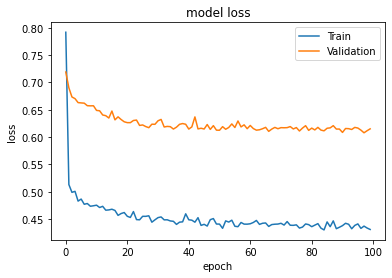

In [53]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation']);

The $R^2$ of the nonlinear AR RNN model is very close to the linear AR model from the previous exercise.  Both of these are also similar to the $R^2$ generated from using `lm()` (`statsmodelsformulas.ols` in Python) in Lab 10.9.6.

## Exercise 12
Consider the RNN fit to the `NYSE` data in Section 10.9.6. Modify the code to allow inclusion of the variable `day_of_week`, and fit the RNN.  Compute the test $R^2$

### Lag-5 Non-Linear AR RNN model with day_of_week variable

In [54]:
categorical_day_of_week = tf.keras.utils.to_categorical(month_df['date'].dt.dayofweek)

day_of_week_df = pd.DataFrame(categorical_day_of_week, columns=['day[mon]', 'day[tues]', 'day[wed]', 'day[thurs]', 'day[fri]'])

xdatad = pd.concat([xdata.reset_index(drop=True), day_of_week_df], axis=1)

In [55]:
arframed = pd.concat(
    [
        xdatad[['log_volume']].reset_index(drop=True),
        lagm(xdatad, 'L1', 1), 
        lagm(xdatad, 'L2', 2),
        lagm(xdatad, 'L3', 3),
        lagm(xdatad, 'L4', 4),
        lagm(xdatad, 'L5', 5)
    ], axis=1
)

arframed = arframed[5:]

In [56]:
arframed.head()

log_volume  L1_DJ_return  L1_log_volume  L1_log_volatility  L1_day[mon]  \
5    0.605868      0.046336       0.224760          -2.500763          0.0   
6   -0.013660     -1.304018       0.605868          -1.365915          1.0   
7    0.042548     -0.006293      -0.013660          -1.505543          0.0   
8   -0.419802      0.377050       0.042548          -1.551386          0.0   
9   -0.556019     -0.411684      -0.419802          -1.597475          0.0   

   L1_day[tues]  L1_day[wed]  L1_day[thurs]  L1_day[fri]  L2_DJ_return  ...  \
5           0.0          0.0            0.0          1.0     -0.431361  ...   
6           0.0          0.0            0.0          0.0      0.046336  ...   
7           1.0          0.0            0.0          0.0     -1.304018  ...   
8           0.0          1.0            0.0          0.0     -0.006293  ...   
9           0.0          0.0            1.0          0.0      0.377050  ...   

   L4_day[thurs]  L4_day[fri]  L5_DJ_return  L5_log_volume  L5_log_volatility  \
5            0.0          0.0     -0.549778       0.175060          -4.356718   
6            0.0          0.0      0.905125       1.517165          -2.528849   
7            1.0          0.0      0.434777       2.283601          -2.417837   
8            0.0          1.0     -0.431361       0.935098          -2.366325   
9            0.0          0.0      0.046336       0.224760          -2.500763   

   L5_day[mon]  L5_day[tues]  L5_day[wed]  L5_day[thurs]  L5_day[fri]  
5          1.0           0.0          0.0            0.0          0.0  
6          0.0           1.0          0.0            0.0          0.0  
7          0.0           0.0          1.0            0.0          0.0  
8          0.0           0.0          0.0            1.0          0.0  
9          0.0           0.0          0.0            0.0          1.0  

[5 rows x 41 columns]

In [57]:
n = arframed.shape[0]
xrnnd = pd.DataFrame(arframed.iloc[:,1:])
xrnnd = np.array(xrnnd)
xrnnd = xrnnd.reshape((n, 8, 5), order='F')
xrnnd = xrnnd[:,:,::-1]
xrnnd = xrnnd.transpose((0,2,1))
xrnnd.shape

(6046, 5, 8)

In [58]:
modeld = tf.keras.models.Sequential(
     [
         tf.keras.layers.SimpleRNN(units=12,
                          dropout=0.1,
                          recurrent_dropout=0.1),
         tf.keras.layers.Dense(units=1)
     ]
)

modeld.compile(optimizer='rmsprop', loss='mse')

In [59]:
history = modeld.fit(
    x = xrnnd[training_mask, :, :],
    y = arframed[training_mask]['log_volume'],
    batch_size = 64, epochs = 200,
    validation_data = (xrnnd[~training_mask, :, :], 
                       arframed[~training_mask]['log_volume']),
    verbose = 0
)

kpred = modeld.predict(xrnnd[~training_mask])
r_2 = 1 - np.mean((kpred.flatten() - arframed[~training_mask]['log_volume'])**2) / V_0
r_2

56/56 [==============================] - 0s 1ms/step


0.46015271737635455

Including the day_of_week_variable using `lm()` (`statsmodelsformulas.ols` in Python) in Lab 10.9.6 slightly increased the $R^2$ to 0.4599 from 0.4132 and we see a similar performance increase when including day_of_week in the SimpleRNN.  Without day_of_week, the $R^2$ was 0.416 in Lab 10.9.6, compared to roughly 0.45 when it's included.

## Exercise 13
Repeat the analysis of Lab 10.9.5 on the `IMDb` data using a similarly structured neural network.  There we used a dictionary size of 10,000.  Conside the effects of varying dictionary size.  Try the values 1000, 3000, 5000, and 10,000, and compare the results.

In [60]:
def run_sentiment_analysis(max_features):

    import rpy2.robjects as robjects
    import matplotlib.pyplot as plt
    import tensorflow as tf
    import numpy as np
    import pandas as pd
    from scipy import sparse
    
    def one_hot(sequences, dimension):
        from scipy import sparse
        from itertools import chain

        seqlen = np.array([], dtype=np.int64)
        for seq in sequences:
            seqlen = np.append(seqlen, len(seq))

        n = len(seqlen)

        rowind = np.repeat(np.arange(0, n), repeats=seqlen)

        # Because R starts indexing at 1 and word_index has a minimum value of 1, everything matches up nicely in R.  However, Python starts indexing at 0 and we need to adjust the values of word_index accordingly.  By subtracting 1 from colind, the first word in our dataset will be in the first column (column 0), just like in R where the first word is in the first column (column 1).
        colind = np.array(list(chain(*sequences))) - 1  #taken from https://stackoverflow.com/questions/52573275/get-all-items-in-a-python-list

        sparse_array = np.zeros(shape=(n, dimension))
        sparse_array[rowind, colind] = 1

        sparse_matrix = sparse.coo_matrix(sparse_array)

        return sparse_matrix
    
    
    print(f'Performing analysis with {max_features} features')
    
    #max_features = 10_000
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=max_features)
    
    x_train_1h = one_hot(x_train, max_features)
    x_test_1h = one_hot(x_test, max_features)

    #x_train_1h.shape
    #x_train_1h.count_nonzero() / (25000 * num_features)
    
    data = robjects.r("""
    set.seed(3)
    ival <- sample(seq(1:25000), 2000)
    """)

    ival = np.sort(np.array(data) - 1)
    ival_mask = pd.DataFrame(x_train_1h.toarray()).index.isin(ival)
    
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(units=16, activation='relu'),
            tf.keras.layers.Dense(units=16, activation='relu'),
            tf.keras.layers.Dense(units=1, activation='sigmoid')
        ]
    )

    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics='accuracy')

    history = model.fit(x=x_train_1h.tocsr()[~ival_mask], 
                        y=y_train[~ival_mask], 
                        epochs=20, batch_size=512, 
                        validation_data=(
                            x_train_1h.tocsr()[ival_mask], y_train[ival_mask]
                        ),
                        verbose = 0
                       )
    
    history2 = model.fit(x = x_train_1h.tocsr()[~ival_mask], 
                     y = y_train[~ival_mask], 
                     epochs=20, batch_size=512, 
                     validation_data=(x_test_1h.tocsr(), y_test),
                     verbose = 0
                    )
    
    fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))
    fig.suptitle('Training/Validation Data')
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('model loss')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['Train', 'Validation'])

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('model accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['Train', 'Validation'])
    
    
    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(2, 1, sharex = True, figsize=(8,6))
    fig.suptitle('Training/Test Data')

    ax[0].plot(history2.history['loss'])
    ax[0].plot(history2.history['val_loss'])
    ax[0].set_title('model loss')
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['Train', 'Test'])

    ax[1].plot(history2.history['accuracy'])
    ax[1].plot(history2.history['val_accuracy'])
    ax[1].set_title('model accuracy')
    ax[1].set_ylabel('accuracy')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['Train', 'Test'])

    plt.tight_layout()
    plt.show()
    
    pred_proba = model.predict(x_test_1h.tocsr())
    pred_classes = pred_proba > 0.5
    acc = np.mean(pred_classes.flatten() == y_test)
    #accuracies.append(acc)
    print()
    print(f'num_features: {max_features}, accuracy: {acc}')
    
    return acc

### Dictionary size: 1000

Performing analysis with 1000 features


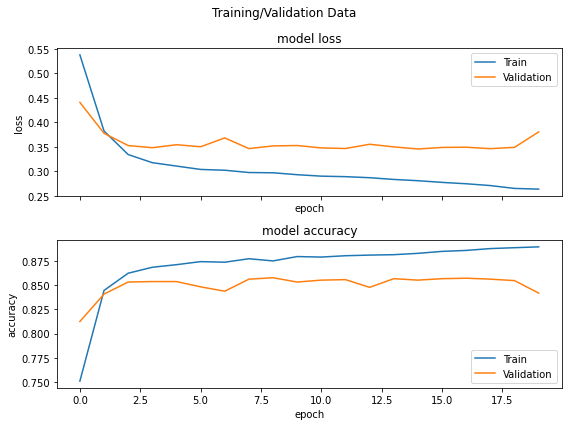

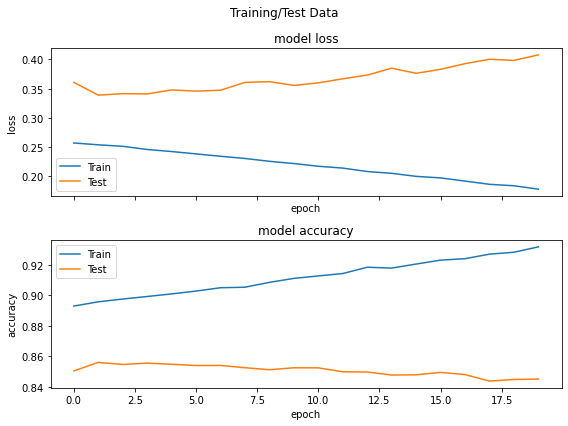

782/782 [==============================] - 1s 996us/step

num_features: 1000, accuracy: 0.84508


In [61]:
acc_1000 = run_sentiment_analysis(1000)

### Dictionary size: 3000

Performing analysis with 3000 features


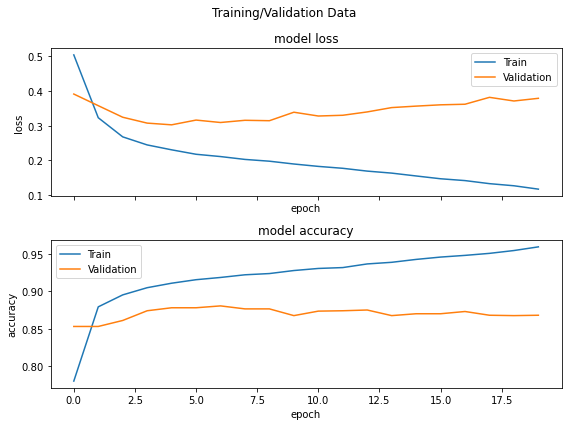

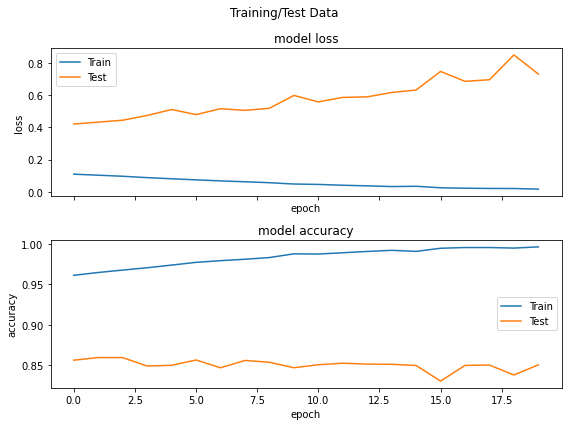

782/782 [==============================] - 1s 1ms/step

num_features: 3000, accuracy: 0.85024


In [62]:
acc_3000 = run_sentiment_analysis(3000)

### Dictionary size: 5000

Performing analysis with 5000 features


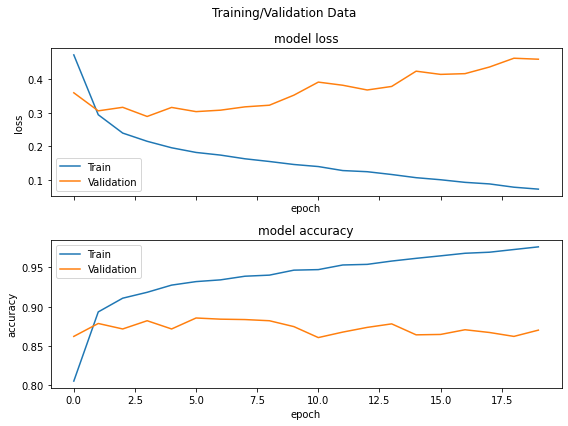

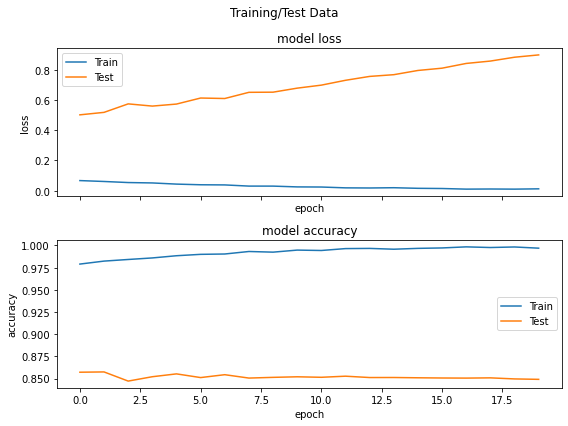

782/782 [==============================] - 1s 1ms/step

num_features: 5000, accuracy: 0.84908


In [63]:
acc_5000 = run_sentiment_analysis(5000)

### Dictionary size: 10000

Performing analysis with 10000 features


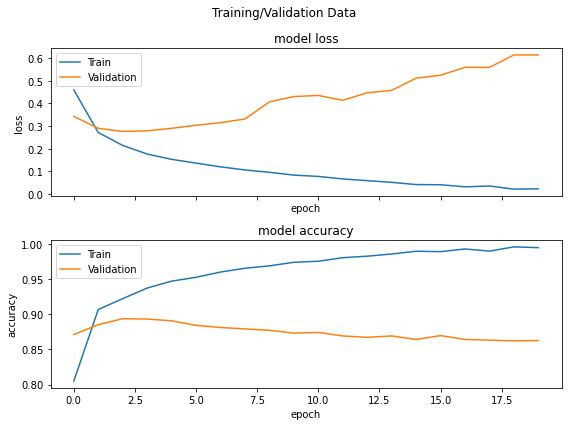

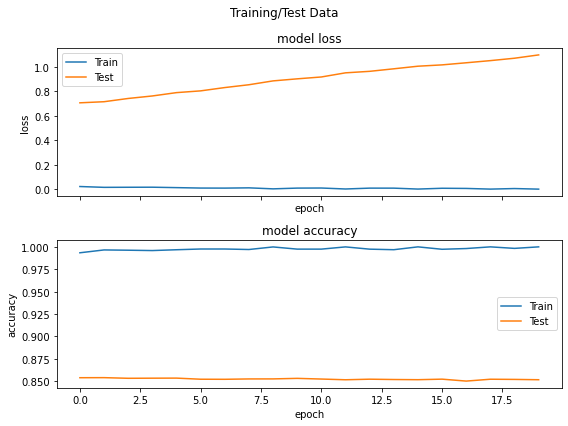

782/782 [==============================] - 1s 1ms/step

num_features: 10000, accuracy: 0.85164


In [64]:
acc_10000 = run_sentiment_analysis(10_000)

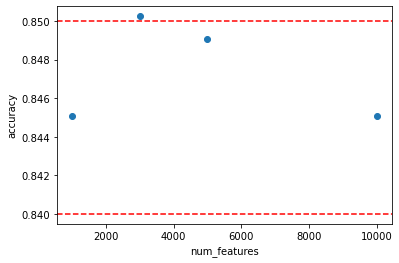

In [65]:
num_features = [1000, 3000, 5000, 10_000]
accuracies = [acc_1000, acc_3000, acc_5000, acc_1000]

plt.scatter(num_features, accuracies)
plt.xlabel('num_features')
plt.ylabel('accuracy')
plt.axhline(0.84, c='r', ls='--')
plt.axhline(0.85, c='r', ls='--');

Varying dictionary sizes didn't seem to change the classification accuracy much.  Accuracy seemed to stay within a 1% interval, from ~84% to ~85%.